# Bag of words approach on lyrics_df

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

plt.style.use('seaborn-poster')

In [2]:
corpus = pd.read_csv('lyrics_df.csv', sep=';')
artists = ['Florence and the Machine', 'Imagine Dragons', 'Queen', 'ABBA']
corpus

,artist,title,lyrics
0,Florence and the Machine,100 years,I believe in you and in our hearts we know the...
1,Florence and the Machine,addicted to love,The lights are on but you re not home Your mi...
2,Florence and the Machine,all this and heaven too,And the heart is hard to translate It has a la...
3,Florence and the Machine,are you hurting the one you love,Are you hurting the one you love You say you v...
4,Florence and the Machine,bedroom hymns,This is as good a place to fall as any We ll b...
...,...,...,...
561,ABBA,winner takes it all,I don t wanna talk about things we ve gone thr...
562,ABBA,wrap your arms around me,When you re so far away At the end of each day...
563,ABBA,you owe me one,Frida Now there s a shadow falling over our f...
564,ABBA,youre there,I tried not to see you Cause I couldn t take t...


## 1 - clean lyrics (Spacy)

In [3]:

model = spacy.load('en_core_web_sm')

In [4]:
# Create function that cleans lyrics
def clean_lyrics(song):
    clean_song = []
    
    # parse the song through the spacy model
    tok_song = model(song)
    
    # loop through words and drop stopwords, drop punctuation
    for word in tok_song:
        if word.is_alpha and not word.is_stop:   # loop through words and drop stopwords, drop punctuation
            clean_song.append(word.lemma_)           # lemmatize the remaining words
    clean_song = ' '.join(clean_song)                # return the lemmatized version to the caller as a string
    return clean_song

In [5]:
corpus['lyrics_clean'] = corpus['lyrics'].apply(clean_lyrics)

In [6]:
corpus

,artist,title,lyrics,lyrics_clean
0,Florence and the Machine,100 years,I believe in you and in our hearts we know the...,believe heart know truth believe love darker g...
1,Florence and the Machine,addicted to love,The lights are on but you re not home Your mi...,light home mind heart sweat body shake kiss ta...
2,Florence and the Machine,all this and heaven too,And the heart is hard to translate It has a la...,heart hard translate language s talk tongue qu...
3,Florence and the Machine,are you hurting the one you love,Are you hurting the one you love You say you v...,hurt love ve find Heaven t find God hurt love ...
4,Florence and the Machine,bedroom hymns,This is as good a place to fall as any We ll b...,good place fall will build alter Maria m knee ...
...,...,...,...,...
561,ABBA,winner takes it all,I don t wanna talk about things we ve gone thr...,don t wanna talk thing ve go s hurt s history ...
562,ABBA,wrap your arms around me,When you re so far away At the end of each day...,far away end day count moment till fade away i...
563,ABBA,you owe me one,Frida Now there s a shadow falling over our f...,Frida s shadow fall face doubt forever heart w...
564,ABBA,youre there,I tried not to see you Cause I couldn t take t...,try Cause couldn t heartache past Wouldn t com...


## 2 - transform your corpus into a matrix (CountVectorizer)

In [8]:
type(corpus['lyrics'])

pandas.core.series.Series

In [9]:
cv = CountVectorizer(stop_words='english')
cv.fit(corpus['lyrics_clean'])

CountVectorizer(stop_words='english')

In [10]:
lyrics_vec = cv.transform(corpus['lyrics_clean'])

## 3 - Normalize the counts (TfidfTransformer)

In [12]:
tf = TfidfTransformer()
lyrics_vec_tf = tf.fit_transform(lyrics_vec)

In [13]:
lyrics_df = pd.DataFrame(lyrics_vec_tf.todense().round(2),  columns=cv.get_feature_names(), index=corpus['artist'])

## 4 - Classification model (Naive Bayes)

**First, add a labels column to your dataframe by factorizing the artist name**

In [14]:
# factorize label column
lyrics_df['artist_fact'] = pd.factorize(lyrics_df.index)[0]

In [15]:
lyrics_df = lyrics_df.drop(list(lyrics_df.filter(regex='^aa')), axis=1) # without spacy 6031 columns
lyrics_df

,abandoned,abel,abide,ablaze,able,abre,absent,absolutely,absolution,aburrida,...,youth,yuh,yup,zarkov,zero,zip,zombie,zoo,zoomin,artist_fact
artist,,,,,,,,,,,,,,,,,,,,,
Florence and the Machine,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Florence and the Machine,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Florence and the Machine,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Florence and the Machine,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Florence and the Machine,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.26,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABBA,0.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
ABBA,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
ABBA,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


**Define model data**

In [16]:
# Split the data into X and y
y = lyrics_df['artist_fact']
X = lyrics_df.reset_index(drop=True).drop(['artist_fact'], axis=1)

,abandoned,abel,abide,ablaze,able,abre,absent,absolutely,absolution,aburrida,...,youngster,youth,yuh,yup,zarkov,zero,zip,zombie,zoo,zoomin
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.26,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
563,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Split it in training and test data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((452, 4908), (114, 4908), (452,), (114,))

**Create baseline with dummy classifier**

In [18]:

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)
# dummy_clf.predict(X_train)

0.42035398230088494

**Create naive bayes classifier**

In [19]:

nb = MultinomialNB(alpha=0.0025)
nb.fit(X_train, y_train)
nb.score(X_train, y_train)

0.995575221238938

**Cross validation**

In [20]:

scores = cross_val_score(nb, X_train, y_train, cv=4, scoring='accuracy')
scores

array([0.69026549, 0.53097345, 0.59292035, 0.62831858])

In [21]:
scores.mean().round(3), scores.std().round(3)

(0.611, 0.058)

**Hyperparameter Optimization**

In [22]:

param_distributions = {
    'alpha' : [x/10000 for x in range(6, 27 , 1)], # it will uniformly sample from that list
}
randomizedcv = RandomizedSearchCV(nb, param_distributions=param_distributions)
randomizedcv.fit(X_train, y_train)
random_results = pd.DataFrame(randomizedcv.cv_results_)
columns = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'param_alpha', 'rank_test_score']
random_results[columns].sort_values('rank_test_score', ascending=True)

,mean_test_score,std_test_score,mean_fit_time,param_alpha,rank_test_score
8,0.619365,0.055150,0.039650,0.0024,1
0,0.617143,0.052931,0.047966,0.0026,2
2,0.617143,0.052931,0.040173,0.0023,2
7,0.617143,0.052931,0.039201,0.0022,2
5,0.614945,0.049409,0.039288,0.0013,5
9,0.614945,0.049409,0.039610,0.0009,5
1,0.614921,0.050517,0.039448,0.0019,7
3,0.614921,0.050517,0.039677,0.0017,7
6,0.614921,0.050517,0.039563,0.0018,7
4,0.612723,0.047754,0.039315,0.0007,10


**Test on validation data**

In [23]:
nb.score(X_val, y_val)

0.5877192982456141

In [24]:
artist_pred = nb.predict(X_train)
artist_pred_val = nb.predict(X_val)

In [25]:


def print_evaluations(ytrue, ypred, model):
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {round(accuracy_score(ytrue, ypred), 3)}')
    print(f'The precision of the model is: {round(precision_score(ytrue, ypred, average="weighted"), 3)}')
    print(f'The recall of the model is: {round(recall_score(ytrue, ypred, average="weighted"), 3)}')
    print(f'The f1-score of the model is: {round(f1_score(ytrue, ypred, average="weighted"), 3)}')
    
    #print confusion matrix
    fig = plt.figure(figsize=(10, 8))
    cm = confusion_matrix(ytrue, ypred)
    print(cm)
    
    #plot the heatmap
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, annot_kws={"size": 14}, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels', fontweight='bold');
    ax.set_ylabel('True labels', fontweight='bold'); 
    ax.set_title('Confusion Matrix - ' + model, fontsize=20, fontweight='bold', pad = 20); 
    ax.xaxis.set_ticklabels(artists, rotation=25, ha='right'); 
    ax.yaxis.set_ticklabels(artists, rotation=0)

How does model Naive Bayes score:
The accuracy of the model is: 0.588
The precision of the model is: 0.586
The recall of the model is: 0.588
The f1-score of the model is: 0.572
[[ 9  1  8  4]
 [ 2  5  9  2]
 [ 3  3 34  4]
 [ 1  1  9 19]]


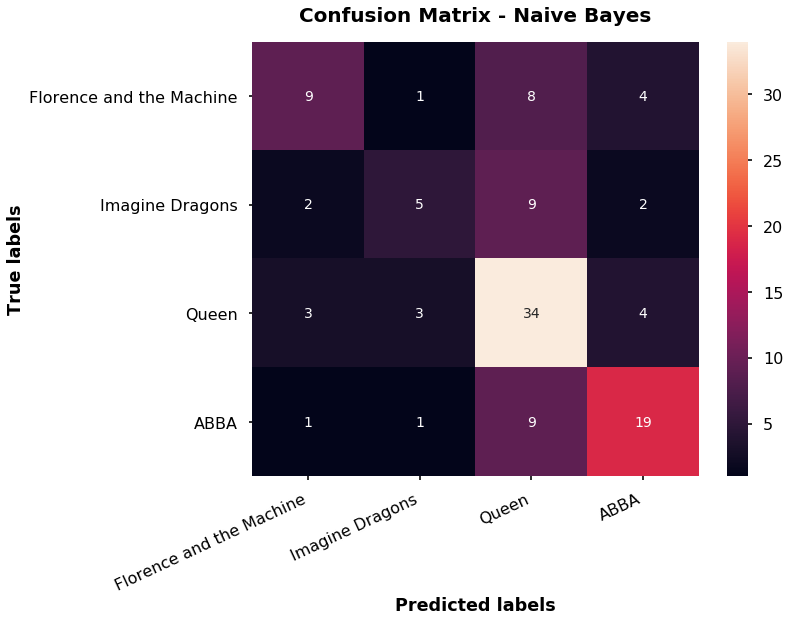

In [26]:
print_evaluations(y_val, artist_pred_val, 'Naive Bayes')

## 5 - Reduce class imbalance (Undersampling, Oversampling)

**Investigate training set for class imbalance**

In [38]:
y_train.value_counts(sort=False)

0     62
1     66
2    190
3    134
Name: artist_fact, dtype: int64

**Create new training sets using undersampling and oversampling techniques**

In [28]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [29]:
rus = RandomUnderSampler(random_state=42) #sampling_strategy={0: 2000} 
nms = NearMiss()
ros = RandomOverSampler(random_state=42)
sms = SMOTE(random_state=42)

In [30]:
Xtrain_rus, ytrain_rus = rus.fit_resample(X_train, y_train)
Xtrain_nms, ytrain_nms = nms.fit_resample(X_train, y_train)
Xtrain_ros, ytrain_ros = ros.fit_resample(X_train, y_train)
Xtrain_sms, ytrain_sms = sms.fit_resample(X_train, y_train)

In [43]:
pd.DataFrame({'rus': ytrain_rus.value_counts(sort=False), 'nms': ytrain_nms.value_counts(sort=False), 'ros': ytrain_ros.value_counts(sort=False), 'sms': ytrain_sms.value_counts(sort=False)})

,rus,nms,ros,sms
0,62,62,190,190
1,62,62,190,190
2,62,62,190,190
3,62,62,190,190


How does model Naive Bayes with RandomUndersampler score:
The accuracy of the model is: 0.588
The precision of the model is: 0.627
The recall of the model is: 0.588
The f1-score of the model is: 0.596
[[14  2  4  2]
 [ 5 11  1  1]
 [ 7  8 26  3]
 [ 6  3  5 16]]


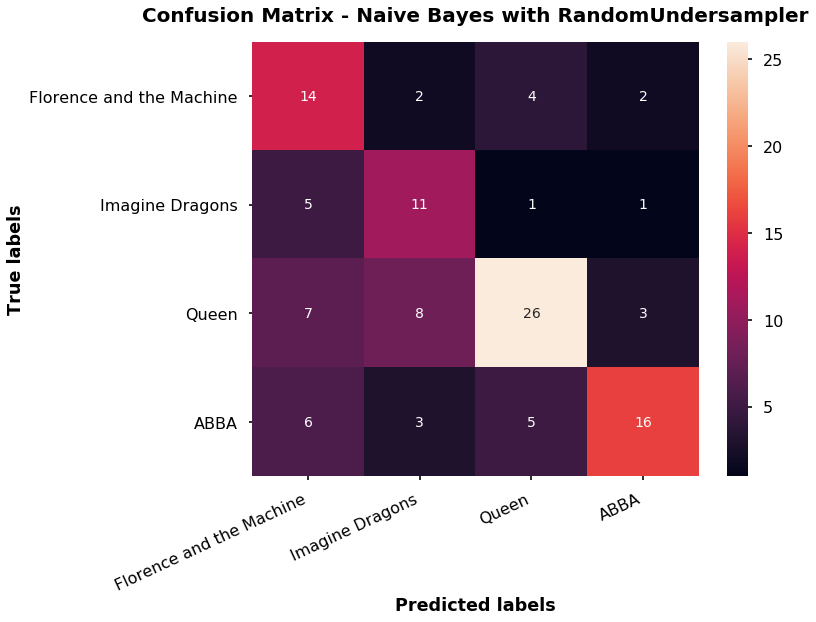

In [49]:
nb.fit(Xtrain_rus, ytrain_rus)
ypred_rus = nb.predict(X_val)
print_evaluations(y_val, ypred_rus, 'Naive Bayes with RandomUndersampler')

How does model Naive Bayes with NearMissSampler score:
The accuracy of the model is: 0.518
The precision of the model is: 0.538
The recall of the model is: 0.518
The f1-score of the model is: 0.519
[[13  1  4  4]
 [ 4 10  2  2]
 [ 5 11 20  8]
 [ 5  3  6 16]]


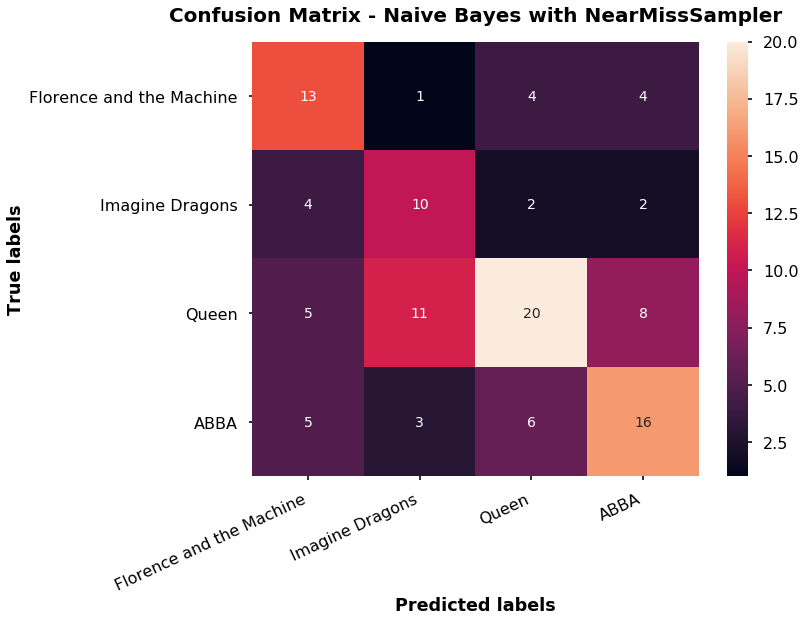

In [47]:
nb.fit(Xtrain_nms, ytrain_rus)
ypred_nms = nb.predict(X_val)
print_evaluations(y_val, ypred_nms, 'Naive Bayes with NearMissSampler')

How does model Naive Bayes with RandomUnderSampler score:
The accuracy of the model is: 0.588
The precision of the model is: 0.613
The recall of the model is: 0.588
The f1-score of the model is: 0.567
[[ 6  1 12  3]
 [ 1  6 10  1]
 [ 2  3 35  4]
 [ 0  0 10 20]]


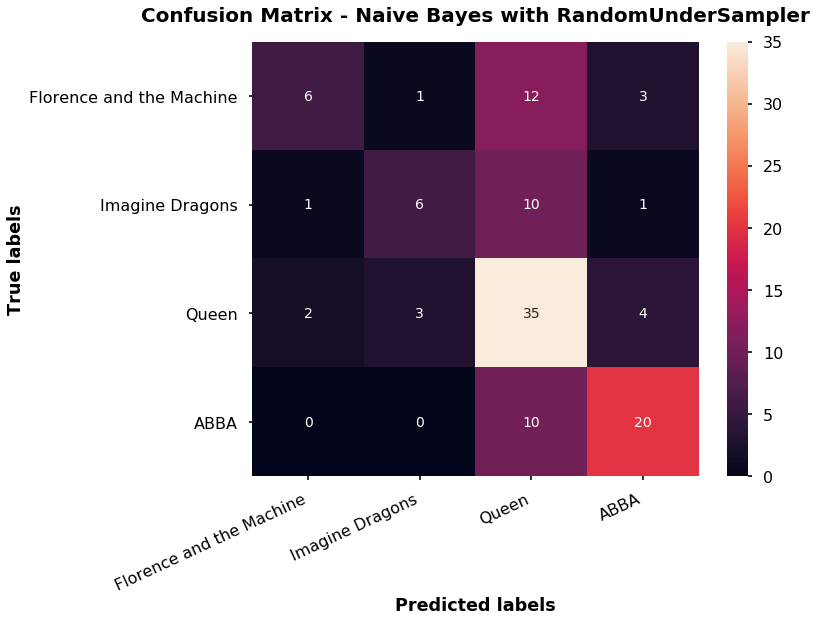

In [48]:
nb.fit(Xtrain_ros, ytrain_ros)
ypred_ros = nb.predict(X_val)
print_evaluations(y_val, ypred_ros, 'Naive Bayes with RandomOversampler')

How does model Naive Bayes with SMOTE score:
The accuracy of the model is: 0.579
The precision of the model is: 0.596
The recall of the model is: 0.579
The f1-score of the model is: 0.554
[[ 5  0 13  4]
 [ 2  6  9  1]
 [ 2  3 35  4]
 [ 0  0 10 20]]


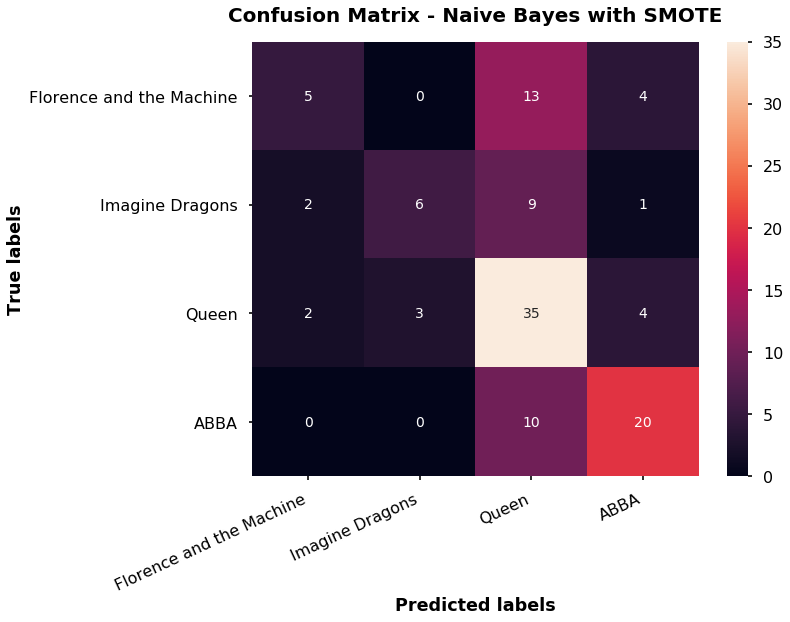

In [51]:
nb.fit(Xtrain_sms, ytrain_sms)
ypred_sms = nb.predict(X_val)
print_evaluations(y_val, ypred_sms, 'Naive Bayes with SMOTE')